<a href="https://colab.research.google.com/gist/tzuhsuan0410/0afe5a0dcf386c46be151c069ceb0ddc/re_expand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
from tensorflow import keras
from keras import backend as clear
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import Adam

# Functions for evaluation
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Note: Some metrics need to be defined manually

In [ ]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE
    
# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator
    
    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

In [ ]:
#load data(sometimes need to use "/")
#df = pd.read_csv('D:/pythonData/python_demo_data/Rainfall_Forecast.csv')
# Colab
df = pd.read_csv('/content/drive/MyDrive/深度學習/0525 ANN/NVDA15-23.csv')
df

,Date,Y,Lag_1,Lag_2,Lag_3
0,2015/1/2,5.032500,5.012500,5.092500,5.140000
1,2015/1/5,4.947500,5.032500,5.012500,5.092500
2,2015/1/6,4.797500,4.947500,5.032500,5.012500
3,2015/1/7,4.785000,4.797500,4.947500,5.032500
4,2015/1/8,4.965000,4.785000,4.797500,4.947500
...,...,...,...,...,...
2109,2023/5/19,312.640015,316.779999,301.779999,292.130005
2110,2023/5/22,311.760010,312.640015,316.779999,301.779999
2111,2023/5/23,306.880005,311.760010,312.640015,316.779999
2112,2023/5/24,305.380005,306.880005,311.760010,312.640015


# 1. Preparations for time-series data

Note: Pandas has a specific data type for time-series data

In [ ]:
# Date is converted into special data type of pandas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2114 entries, 0 to 2113
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        2114 non-null   object 
 1   Y           2114 non-null   float64
 2   Lag_1       2114 non-null   float64
 3   Lag_2       2114 non-null   float64
 4   Lag_3       2114 non-null   float64
 5   Unnamed: 5  2114 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 99.2+ KB


# 2. Creating time lags as predictor variables

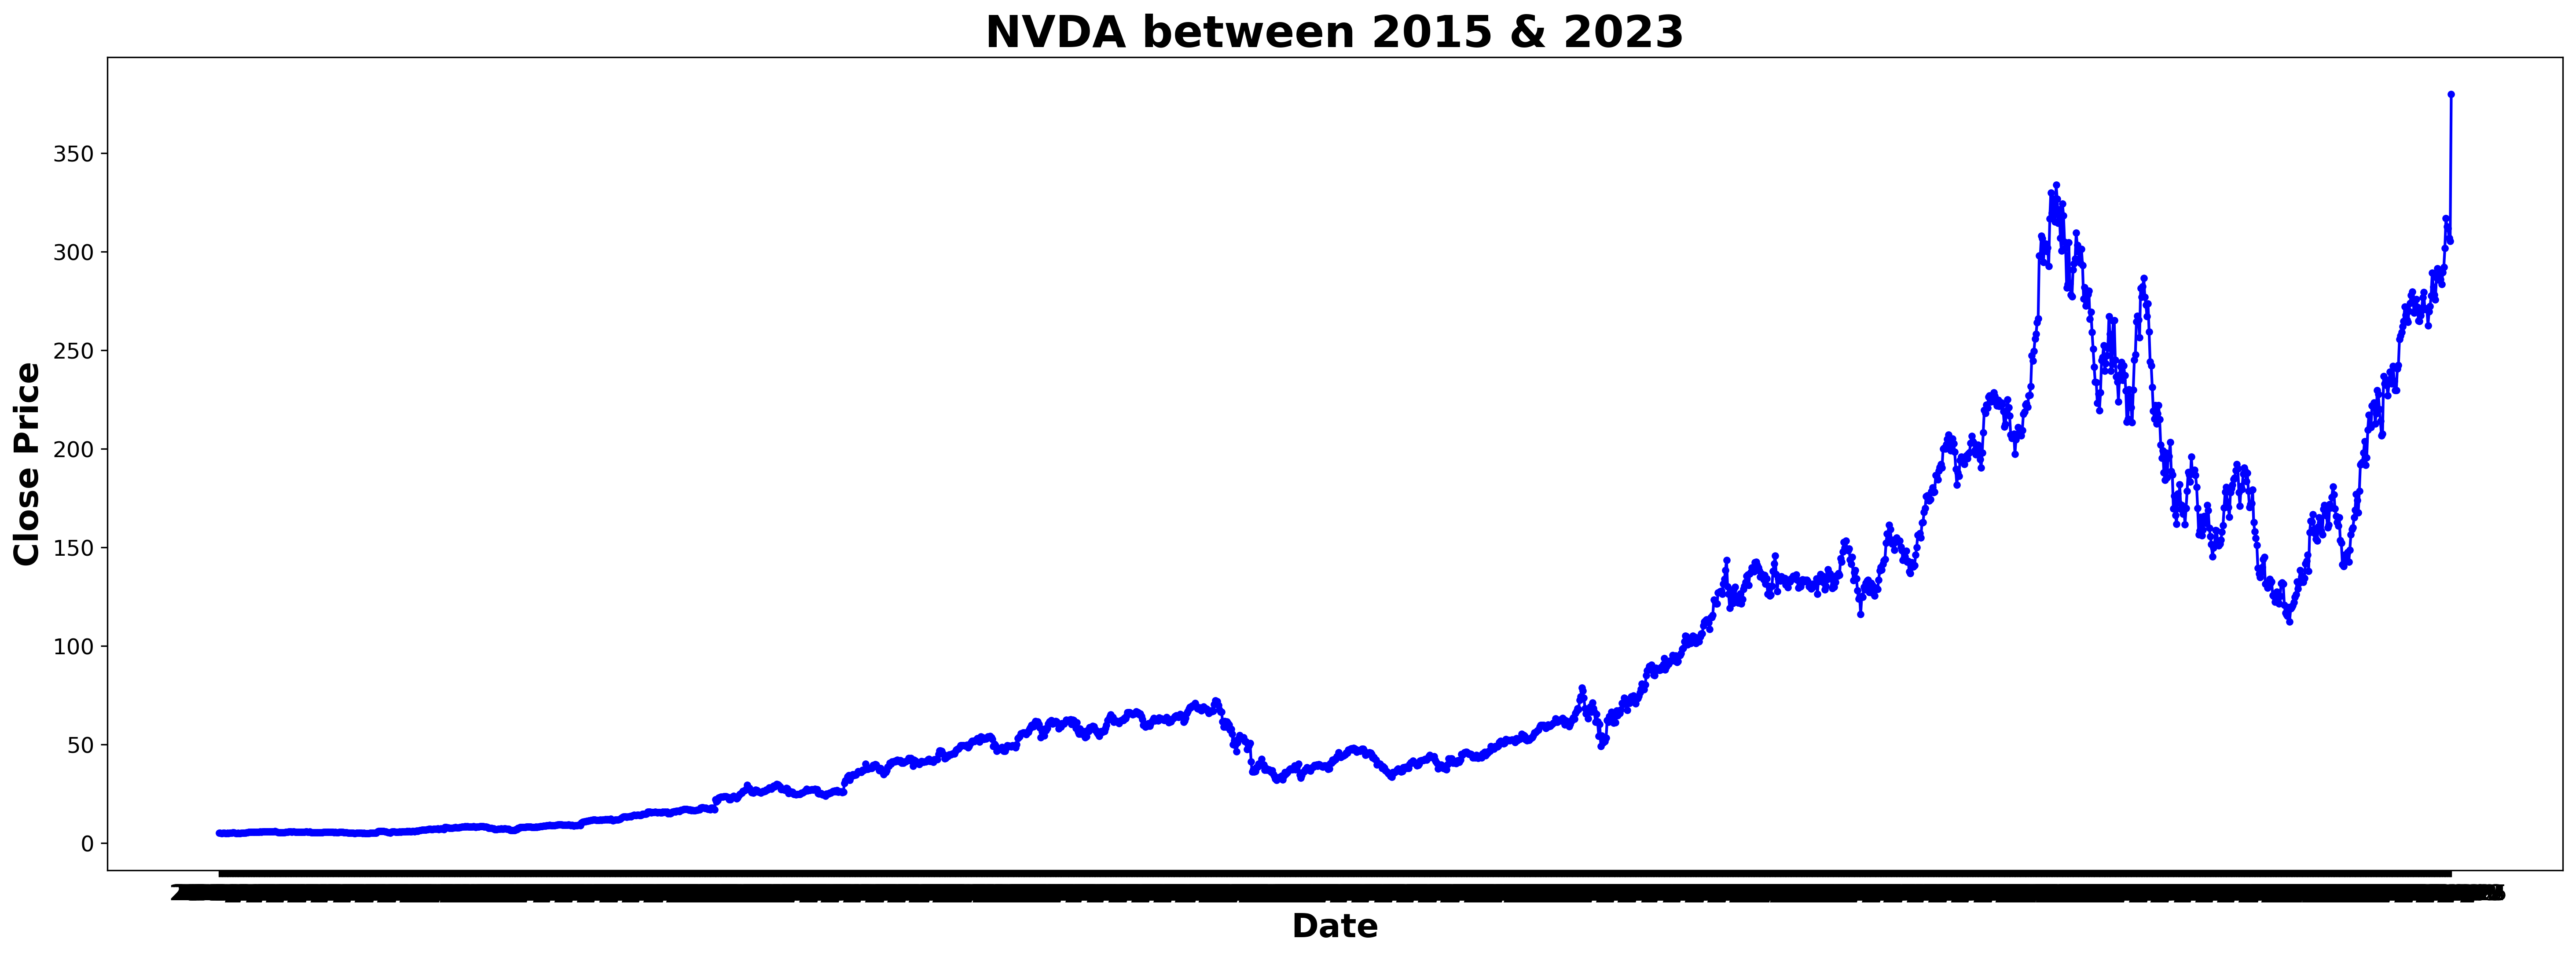

In [ ]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('NVDA between 2015 & 2023',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Close Price',fontsize=18,weight='bold')

# Actual by predicted plot
plt.plot(df['Date'],df['Y'],marker='.',color='blue')

# Set the axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Important!: Be caution when dealing with time-series data

python do have various packages and function that can deal with time-series data with ease, however, make sure that you understand the fundamental first!

# 3. Data preprocessing under time-series structure

A total of 21 years are in the data set. In this practice, we will use the last three years of data as the testing set

In [ ]:
# Train data
Forecast_train_data=df.iloc[0:1688,:].copy()
Forecast_train_data

,Date,Y,Lag_1,Lag_2,Lag_3
0,2015/1/2,5.032500,5.012500,5.092500,5.140000
1,2015/1/5,4.947500,5.032500,5.012500,5.092500
2,2015/1/6,4.797500,4.947500,5.032500,5.012500
3,2015/1/7,4.785000,4.797500,4.947500,5.032500
4,2015/1/8,4.965000,4.785000,4.797500,4.947500
...,...,...,...,...,...
1683,2021/9/9,221.770004,223.389999,226.619995,228.429993
1684,2021/9/10,224.779999,221.770004,223.389999,226.619995
1685,2021/9/13,221.520004,224.779999,221.770004,223.389999
1686,2021/9/14,222.419998,221.520004,224.779999,221.770004


In [ ]:
# Test data
Forecast_test_data=df.iloc[1688:,:].copy()
Forecast_test_data

,Date,Y,Lag_1,Lag_2,Lag_3
1688,2021/9/16,222.419998,223.410004,222.419998,221.520004
1689,2021/9/17,219.000000,222.419998,223.410004,222.419998
1690,2021/9/20,211.130005,219.000000,222.419998,223.410004
1691,2021/9/21,212.460007,211.130005,219.000000,222.419998
1692,2021/9/22,219.410004,212.460007,211.130005,219.000000
...,...,...,...,...,...
2109,2023/5/19,312.640015,316.779999,301.779999,292.130005
2110,2023/5/22,311.760010,312.640015,316.779999,301.779999
2111,2023/5/23,306.880005,311.760010,312.640015,316.779999
2112,2023/5/24,305.380005,306.880005,311.760010,312.640015


# 4. Prepare time-series data for train/validation structure manually

Here we have a total of 18 years of data in training data set that are ready to be further splitted into training and validation data set

18 years of data can be evenlly divided into 6 portions (3 years in each portion)

# Expanding window

In [ ]:
# Expanding 1
Exp_training_1=Forecast_train_data.iloc[0:422,:].copy()
Exp_val_1=Forecast_train_data.iloc[422:844,:].copy()


In [ ]:
# Expanding 2
Exp_training_2=Forecast_train_data.iloc[0:844,:].copy()
Exp_val_2=Forecast_train_data.iloc[844:1266,:].copy()

In [ ]:
# Expanding 3
Exp_training_3=Forecast_train_data.iloc[0:1266,:].copy()
Exp_val_3=Forecast_train_data.iloc[1266:,:].copy()

# 5. Set dependent variable(Y or target) & independent variable(X) 

In [ ]:
#set x (make prediction)
# Train
x_train=Exp_training_1.drop(['Date','Y'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']

# Validation
x_val=Exp_val_1.drop(['Date','Y'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['Lag_1','Lag_2','Lag_3']

#set y (want to predict)
y_train=Exp_training_1['Y'].copy()
y_val=Exp_val_1['Y'].copy()




In [ ]:
#set x (make prediction)
# Train
x_train=Exp_training_2.drop(['Date','Y'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']

# Validation
x_val=Exp_val_2.drop(['Date','Y'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['Lag_1','Lag_2','Lag_3']

#set y (want to predict)
y_train=Exp_training_2['Y'].copy()
y_val=Exp_val_2['Y'].copy()




In [ ]:
#set x (make prediction)
# Train
x_train=Exp_training_3.drop(['Date','Y'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']

# Validation
x_val=Exp_val_3.drop(['Date','Y'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['Lag_1','Lag_2','Lag_3']

#set y (want to predict)
y_train=Exp_training_3['Y'].copy()
y_val=Exp_val_3['Y'].copy()




# 6. Creating Net 

In [ ]:
# Quick recap: Total of 12 features in the data set
scaled_x_train.head()

,Lag_1,Lag_2,Lag_3
0,0.056627,0.056896,0.049364
1,0.055659,0.056627,0.056896
2,0.056439,0.055659,0.056627
3,0.057918,0.056439,0.055659
4,0.054341,0.057918,0.056439


In [ ]:
# Tips: Using shape to call the amount of features in the data set 
input_features=scaled_x_train.shape[1]
print('Amount of features:',input_features)

Amount of features: 3


# Important: Define customized loss function (RMSE)

In [ ]:
from keras.losses import mse
from keras.backend import sqrt

def my_RMSE(y_true, y_pred):
    return sqrt(mse(y_true, y_pred))

# Register custom object
#from keras.utils.generic_utils import get_custom_objects for pc
from tensorflow.keras.saving import get_custom_objects
get_custom_objects().update({'my_RMSE': my_RMSE})

Note: As far as I know when I'm preparing this in-class material, keras does not have a built-in RMSE function. Rumor has it that a RMSE function is hidden in the latest version, however it needs to be confirmed. For instance, defining RMSE ourself is not difficult, just don't forget to register our custom functions.   

# Sequential style coding for creating net

In [ ]:
# Some self define functions for building deep neural networks
def dense_generator(model_name,layers,last_layer_neurons,activation_fun='relu'):
    n=last_layer_neurons
    neurons=n
    for i in range(0,layers):
        neurons=neurons*2
        model_name.add(Dense(units=neurons, activation=activation_fun))

In [ ]:
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=6, input_dim=3, activation='relu'))

# 6.3 Add second hidden layer
model.add(Dense(units=12, activation='linear'))

# 6.4 Add third hidden layer
model.add(Dense(units=24, activation='relu'))
model.add(Dropout(rate=0.002))
model.add(Dense(units=48, activation='linear'))
model.add(Dropout(rate=0.03))
model.add(Dense(units=96, activation='relu'))




# 6.5 Add output layer
model.add(Dense(units=1, activation='linear'))

# 6.6 Compile the defined Net
#opt=SGD(learning_rate=0.0001,momentum=0.5)
opt=Adam(learning_rate=0.001,beta_1=0.95)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 48)                1200      
                                                                 
 dropout_1 (Dropout)         (None, 48)                0         
                                                                 
 dense_4 (Dense)             (None, 96)                4

In [ ]:
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=6, input_dim=3, activation='relu'))

# 6.3 Add second hidden layer
model.add(Dense(units=12, activation='linear'))

# 6.4 Add third hidden layer
model.add(Dense(units=24, activation='relu'))
model.add(Dropout(rate=0.002))
model.add(Dense(units=48, activation='linear'))
model.add(Dropout(rate=0.03))
model.add(Dense(units=96, activation='relu'))





# 6.5 Add output layer
model.add(Dense(units=1, activation='linear'))

# 6.6 Compile the defined Net
#opt=SGD(learning_rate=0.0001,momentum=0.5)
opt=Adam(learning_rate=0.0001,beta_1=0.95)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 48)                1200      
                                                                 
 dropout_1 (Dropout)         (None, 48)                0         
                                                                 
 dense_4 (Dense)             (None, 96)                4

In [ ]:
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=6, input_dim=3, activation='relu'))

# 6.3 Add second hidden layer
model.add(Dense(units=12, activation='linear'))

# 6.4 Add third hidden layer
model.add(Dense(units=24, activation='relu'))
model.add(Dropout(rate=0.002))
model.add(Dense(units=48, activation='linear'))
model.add(Dropout(rate=0.03))
model.add(Dense(units=96, activation='relu'))





# 6.5 Add output layer
model.add(Dense(units=1, activation='linear'))

# 6.6 Compile the defined Net
#opt=SGD(learning_rate=0.0001,momentum=0.5)
opt=Adam(learning_rate=0.00001,beta_1=0.95)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 48)                1200      
                                                                 
 dropout_1 (Dropout)         (None, 48)                0         
                                                                 
 dense_4 (Dense)             (None, 96)                4

Note: Remember to clear the session or else some of the left neurans may cause trouble while fitting

# 7. Fit the model (train/validation)

In [ ]:
# 7.1 Store in the history for more useful information
history=model.fit(scaled_x_train, y_train, epochs=300, batch_size=32,verbose=1,validation_data=(scaled_x_val, y_val))

Epoch 1/300
14/14 [==============================] - 1s 26ms/step - loss: 7.5638 - mean_absolute_percentage_error: 97.9762 - val_loss: 37.7200 - val_mean_absolute_percentage_error: 98.2652
Epoch 2/300
14/14 [==============================] - 0s 9ms/step - loss: 6.8827 - mean_absolute_percentage_error: 89.5271 - val_loss: 36.1322 - val_mean_absolute_percentage_error: 94.1875
Epoch 3/300
14/14 [==============================] - 0s 11ms/step - loss: 5.1379 - mean_absolute_percentage_error: 67.7968 - val_loss: 32.0950 - val_mean_absolute_percentage_error: 83.7688
Epoch 4/300
14/14 [==============================] - 0s 9ms/step - loss: 1.6443 - mean_absolute_percentage_error: 22.1237 - val_loss: 24.9525 - val_mean_absolute_percentage_error: 65.1789
Epoch 5/300
14/14 [==============================] - 0s 13ms/step - loss: 1.2696 - mean_absolute_percentage_error: 14.0774 - val_loss: 28.4289 - val_mean_absolute_percentage_error: 74.0448
Epoch 6/300
14/14 [==============================] - 0s 6

In [ ]:
# 7.1 Store in the history for more useful information
history=model.fit(scaled_x_train, y_train, epochs=300, batch_size=32,verbose=1,validation_data=(scaled_x_val, y_val))

Epoch 1/300
14/14 [==============================] - 1s 28ms/step - loss: 7.7213 - mean_absolute_percentage_error: 99.8704 - val_loss: 38.3704 - val_mean_absolute_percentage_error: 99.9034
Epoch 2/300
14/14 [==============================] - 0s 8ms/step - loss: 7.6897 - mean_absolute_percentage_error: 99.4742 - val_loss: 38.3245 - val_mean_absolute_percentage_error: 99.7839
Epoch 3/300
14/14 [==============================] - 0s 6ms/step - loss: 7.6544 - mean_absolute_percentage_error: 99.0323 - val_loss: 38.2734 - val_mean_absolute_percentage_error: 99.6508
Epoch 4/300
14/14 [==============================] - 0s 6ms/step - loss: 7.6153 - mean_absolute_percentage_error: 98.5452 - val_loss: 38.2160 - val_mean_absolute_percentage_error: 99.5000
Epoch 5/300
14/14 [==============================] - 0s 5ms/step - loss: 7.5697 - mean_absolute_percentage_error: 97.9563 - val_loss: 38.1483 - val_mean_absolute_percentage_error: 99.3208
Epoch 6/300
14/14 [==============================] - 0s 6ms

In [ ]:
# 7.1 Store in the history for more useful information
history=model.fit(scaled_x_train, y_train, epochs=300, batch_size=32,verbose=1,validation_data=(scaled_x_val, y_val))

Epoch 1/300
14/14 [==============================] - 1s 19ms/step - loss: 7.7199 - mean_absolute_percentage_error: 99.8865 - val_loss: 38.3844 - val_mean_absolute_percentage_error: 99.9471
Epoch 2/300
14/14 [==============================] - 0s 6ms/step - loss: 7.7166 - mean_absolute_percentage_error: 99.8453 - val_loss: 38.3796 - val_mean_absolute_percentage_error: 99.9347
Epoch 3/300
14/14 [==============================] - 0s 5ms/step - loss: 7.7137 - mean_absolute_percentage_error: 99.8083 - val_loss: 38.3749 - val_mean_absolute_percentage_error: 99.9224
Epoch 4/300
14/14 [==============================] - 0s 5ms/step - loss: 7.7097 - mean_absolute_percentage_error: 99.7617 - val_loss: 38.3701 - val_mean_absolute_percentage_error: 99.9099
Epoch 5/300
14/14 [==============================] - 0s 5ms/step - loss: 7.7064 - mean_absolute_percentage_error: 99.7200 - val_loss: 38.3653 - val_mean_absolute_percentage_error: 99.8975
Epoch 6/300
14/14 [==============================] - 0s 6ms

In [ ]:
# 7.1 Store in the history for more useful information
history=model.fit(scaled_x_train, y_train, epochs=300, batch_size=32,verbose=1,validation_data=(scaled_x_val, y_val))

Epoch 1/300
27/27 [==============================] - 1s 11ms/step - loss: 22.4604 - mean_absolute_percentage_error: 96.3617 - val_loss: 47.4572 - val_mean_absolute_percentage_error: 96.0391
Epoch 2/300
27/27 [==============================] - 0s 4ms/step - loss: 18.4904 - mean_absolute_percentage_error: 70.5858 - val_loss: 37.8754 - val_mean_absolute_percentage_error: 76.9342
Epoch 3/300
27/27 [==============================] - 0s 5ms/step - loss: 9.9540 - mean_absolute_percentage_error: 68.3686 - val_loss: 13.7743 - val_mean_absolute_percentage_error: 29.2686
Epoch 4/300
27/27 [==============================] - 0s 3ms/step - loss: 6.2065 - mean_absolute_percentage_error: 65.7621 - val_loss: 21.1634 - val_mean_absolute_percentage_error: 44.9980
Epoch 5/300
27/27 [==============================] - 0s 3ms/step - loss: 2.3617 - mean_absolute_percentage_error: 21.3223 - val_loss: 20.3047 - val_mean_absolute_percentage_error: 45.0354
Epoch 6/300
27/27 [==============================] - 0s 4

In [ ]:
# 7.1 Store in the history for more useful information
history=model.fit(scaled_x_train, y_train, epochs=300, batch_size=32,verbose=1,validation_data=(scaled_x_val, y_val))

Epoch 1/300
27/27 [==============================] - 1s 10ms/step - loss: 22.9724 - mean_absolute_percentage_error: 99.6111 - val_loss: 49.2852 - val_mean_absolute_percentage_error: 99.6575
Epoch 2/300
27/27 [==============================] - 0s 3ms/step - loss: 22.8867 - mean_absolute_percentage_error: 99.1301 - val_loss: 49.1698 - val_mean_absolute_percentage_error: 99.4335
Epoch 3/300
27/27 [==============================] - 0s 3ms/step - loss: 22.7836 - mean_absolute_percentage_error: 98.5417 - val_loss: 49.0307 - val_mean_absolute_percentage_error: 99.1623
Epoch 4/300
27/27 [==============================] - 0s 4ms/step - loss: 22.6555 - mean_absolute_percentage_error: 97.7908 - val_loss: 48.8546 - val_mean_absolute_percentage_error: 98.8173
Epoch 5/300
27/27 [==============================] - 0s 3ms/step - loss: 22.4898 - mean_absolute_percentage_error: 96.8359 - val_loss: 48.6217 - val_mean_absolute_percentage_error: 98.3623
Epoch 6/300
27/27 [==============================] - 0

In [ ]:
# 7.1 Store in the history for more useful information
history=model.fit(scaled_x_train, y_train, epochs=300, batch_size=32,verbose=1,validation_data=(scaled_x_val, y_val))

Epoch 1/300
27/27 [==============================] - 1s 14ms/step - loss: 23.0670 - mean_absolute_percentage_error: 99.9857 - val_loss: 49.4617 - val_mean_absolute_percentage_error: 99.9916
Epoch 2/300
27/27 [==============================] - 0s 5ms/step - loss: 23.0633 - mean_absolute_percentage_error: 99.9527 - val_loss: 49.4578 - val_mean_absolute_percentage_error: 99.9833
Epoch 3/300
27/27 [==============================] - 0s 4ms/step - loss: 23.0593 - mean_absolute_percentage_error: 99.9176 - val_loss: 49.4537 - val_mean_absolute_percentage_error: 99.9746
Epoch 4/300
27/27 [==============================] - 0s 4ms/step - loss: 23.0552 - mean_absolute_percentage_error: 99.8808 - val_loss: 49.4494 - val_mean_absolute_percentage_error: 99.9655
Epoch 5/300
27/27 [==============================] - 0s 4ms/step - loss: 23.0508 - mean_absolute_percentage_error: 99.8431 - val_loss: 49.4449 - val_mean_absolute_percentage_error: 99.9560
Epoch 6/300
27/27 [==============================] - 0

In [ ]:
# 7.1 Store in the history for more useful information
history=model.fit(scaled_x_train, y_train, epochs=300, batch_size=32,verbose=1,validation_data=(scaled_x_val, y_val))

Epoch 1/300
40/40 [==============================] - 1s 8ms/step - loss: 30.2254 - mean_absolute_percentage_error: 93.4580 - val_loss: 122.0287 - val_mean_absolute_percentage_error: 95.7973
Epoch 2/300
40/40 [==============================] - 0s 3ms/step - loss: 15.6330 - mean_absolute_percentage_error: 54.7186 - val_loss: 84.1403 - val_mean_absolute_percentage_error: 65.8689
Epoch 3/300
40/40 [==============================] - 0s 3ms/step - loss: 5.7925 - mean_absolute_percentage_error: 45.2756 - val_loss: 89.3223 - val_mean_absolute_percentage_error: 70.5515
Epoch 4/300
40/40 [==============================] - 0s 3ms/step - loss: 2.9981 - mean_absolute_percentage_error: 24.5176 - val_loss: 93.5367 - val_mean_absolute_percentage_error: 74.6482
Epoch 5/300
40/40 [==============================] - 0s 4ms/step - loss: 1.3513 - mean_absolute_percentage_error: 5.4869 - val_loss: 93.4001 - val_mean_absolute_percentage_error: 74.8823
Epoch 6/300
40/40 [==============================] - 0s 4m

In [ ]:
# 7.1 Store in the history for more useful information
history=model.fit(scaled_x_train, y_train, epochs=300, batch_size=32,verbose=1,validation_data=(scaled_x_val, y_val))

Epoch 1/300
40/40 [==============================] - 1s 7ms/step - loss: 31.7489 - mean_absolute_percentage_error: 99.5857 - val_loss: 127.1805 - val_mean_absolute_percentage_error: 99.8369
Epoch 2/300
40/40 [==============================] - 0s 3ms/step - loss: 31.5712 - mean_absolute_percentage_error: 98.8479 - val_loss: 126.9571 - val_mean_absolute_percentage_error: 99.6598
Epoch 3/300
40/40 [==============================] - 0s 3ms/step - loss: 31.2991 - mean_absolute_percentage_error: 97.6687 - val_loss: 126.5880 - val_mean_absolute_percentage_error: 99.3671
Epoch 4/300
40/40 [==============================] - 0s 4ms/step - loss: 30.8462 - mean_absolute_percentage_error: 95.7088 - val_loss: 125.9883 - val_mean_absolute_percentage_error: 98.8900
Epoch 5/300
40/40 [==============================] - 0s 3ms/step - loss: 30.1099 - mean_absolute_percentage_error: 92.4164 - val_loss: 125.0018 - val_mean_absolute_percentage_error: 98.1059
Epoch 6/300
40/40 [==============================]

In [ ]:
# 7.1 Store in the history for more useful information
history=model.fit(scaled_x_train, y_train, epochs=300, batch_size=32,verbose=1,validation_data=(scaled_x_val, y_val))

Epoch 1/300
40/40 [==============================] - 1s 8ms/step - loss: 31.8147 - mean_absolute_percentage_error: 99.8560 - val_loss: 127.3281 - val_mean_absolute_percentage_error: 99.9519
Epoch 2/300
40/40 [==============================] - 0s 3ms/step - loss: 31.7995 - mean_absolute_percentage_error: 99.7991 - val_loss: 127.3120 - val_mean_absolute_percentage_error: 99.9395
Epoch 3/300
40/40 [==============================] - 0s 3ms/step - loss: 31.7846 - mean_absolute_percentage_error: 99.7400 - val_loss: 127.2953 - val_mean_absolute_percentage_error: 99.9267
Epoch 4/300
40/40 [==============================] - 0s 3ms/step - loss: 31.7675 - mean_absolute_percentage_error: 99.6749 - val_loss: 127.2786 - val_mean_absolute_percentage_error: 99.9137
Epoch 5/300
40/40 [==============================] - 0s 3ms/step - loss: 31.7523 - mean_absolute_percentage_error: 99.6125 - val_loss: 127.2611 - val_mean_absolute_percentage_error: 99.9001
Epoch 6/300
40/40 [==============================]

In [ ]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])

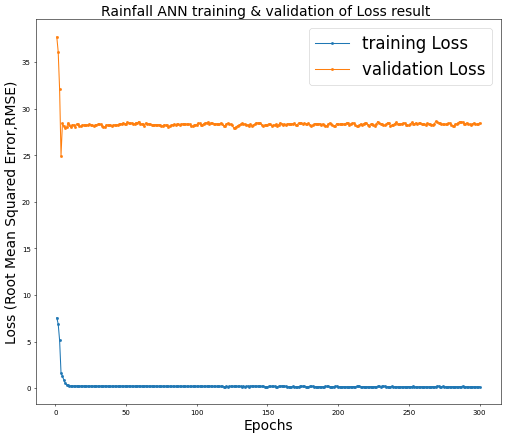

In [ ]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=50)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Root Mean Squared Error,RMSE)',fontsize=20)
plt.title('Rainfall ANN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

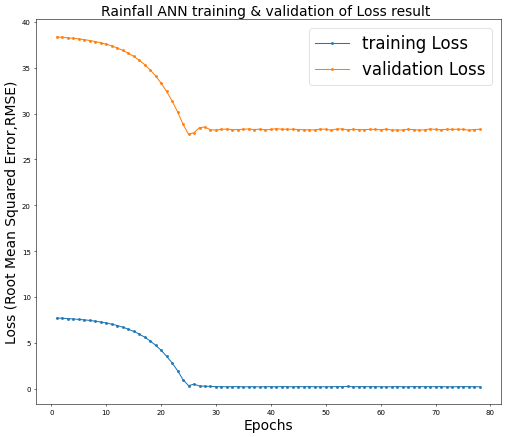

In [ ]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=50)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Root Mean Squared Error,RMSE)',fontsize=20)
plt.title('Rainfall ANN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

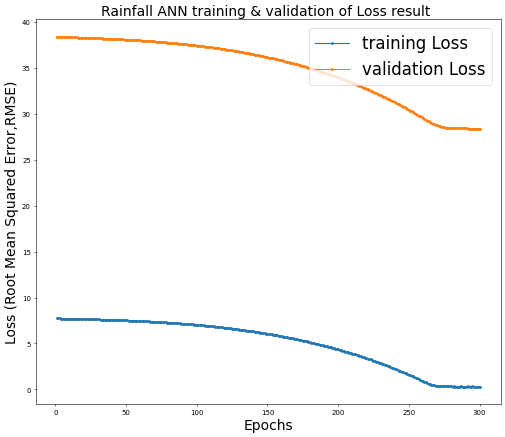

In [ ]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=50)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Root Mean Squared Error,RMSE)',fontsize=20)
plt.title('Rainfall ANN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

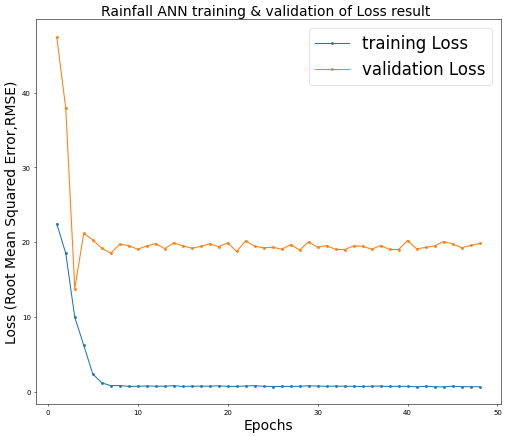

In [ ]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=50)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Root Mean Squared Error,RMSE)',fontsize=20)
plt.title('Rainfall ANN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

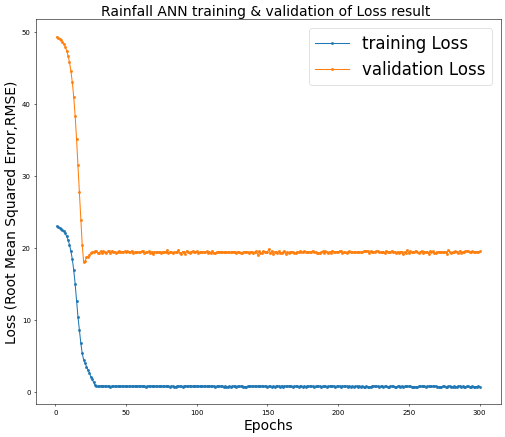

In [ ]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=50)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Root Mean Squared Error,RMSE)',fontsize=20)
plt.title('Rainfall ANN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

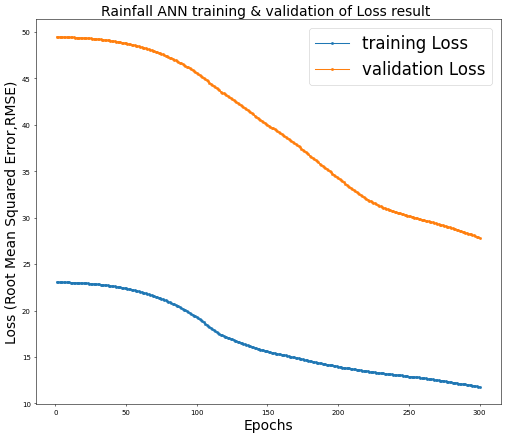

In [ ]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=50)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Root Mean Squared Error,RMSE)',fontsize=20)
plt.title('Rainfall ANN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

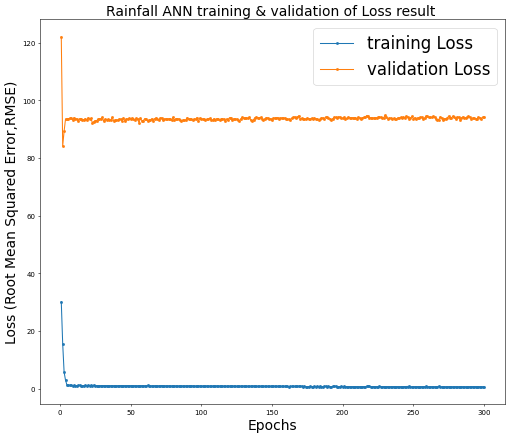

In [ ]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=50)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Root Mean Squared Error,RMSE)',fontsize=20)
plt.title('Rainfall ANN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

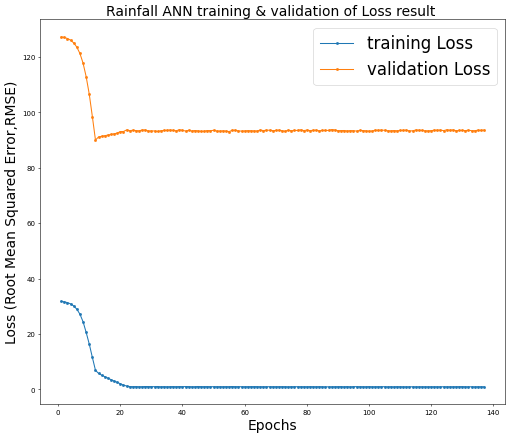

In [ ]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=50)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Root Mean Squared Error,RMSE)',fontsize=20)
plt.title('Rainfall ANN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

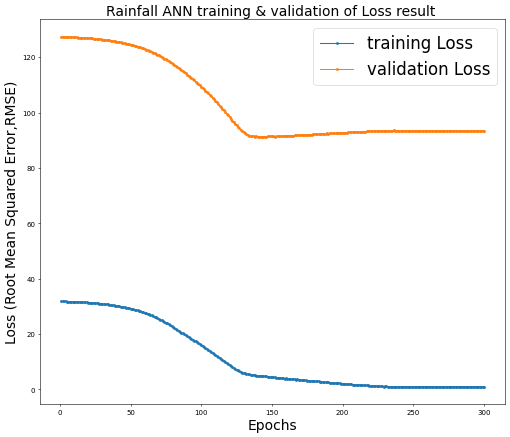

In [ ]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=50)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Root Mean Squared Error,RMSE)',fontsize=20)
plt.title('Rainfall ANN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

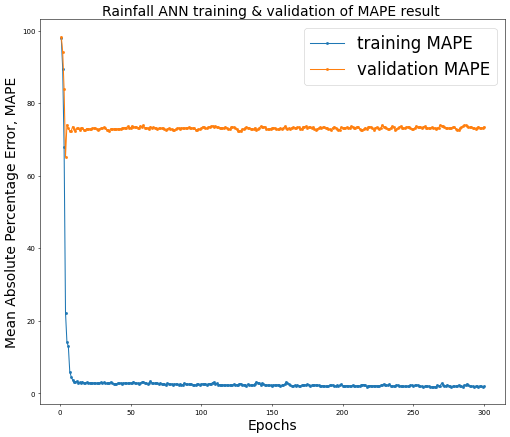

In [ ]:
# 7.2 Plot the history of training and validation
training_acc_values=modeling_result['mean_absolute_percentage_error']
val_acc_values=modeling_result['val_mean_absolute_percentage_error']
epochs=range(1,len(training_acc_values)+1)

plt.figure(figsize=(12,10),dpi=50)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Mean Absolute Percentage Error, MAPE',fontsize=20)
plt.title('Rainfall ANN training & validation of MAPE result ',fontsize=20)

plt.plot(epochs, training_acc_values,marker='.',label='training MAPE')
plt.plot(epochs, val_acc_values,marker='.',label='validation MAPE')
plt.legend(loc=1,fontsize=24)
plt.show()

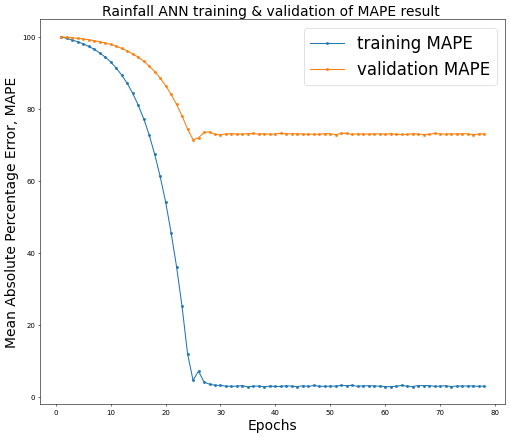

In [ ]:
# 7.2 Plot the history of training and validation
training_acc_values=modeling_result['mean_absolute_percentage_error']
val_acc_values=modeling_result['val_mean_absolute_percentage_error']
epochs=range(1,len(training_acc_values)+1)

plt.figure(figsize=(12,10),dpi=50)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Mean Absolute Percentage Error, MAPE',fontsize=20)
plt.title('Rainfall ANN training & validation of MAPE result ',fontsize=20)

plt.plot(epochs, training_acc_values,marker='.',label='training MAPE')
plt.plot(epochs, val_acc_values,marker='.',label='validation MAPE')
plt.legend(loc=1,fontsize=24)
plt.show()

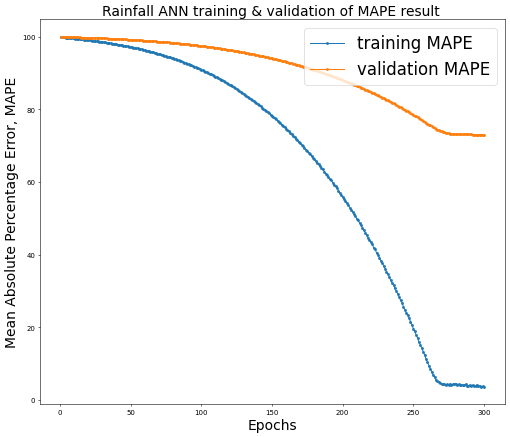

In [ ]:
# 7.2 Plot the history of training and validation
training_acc_values=modeling_result['mean_absolute_percentage_error']
val_acc_values=modeling_result['val_mean_absolute_percentage_error']
epochs=range(1,len(training_acc_values)+1)

plt.figure(figsize=(12,10),dpi=50)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Mean Absolute Percentage Error, MAPE',fontsize=20)
plt.title('Rainfall ANN training & validation of MAPE result ',fontsize=20)

plt.plot(epochs, training_acc_values,marker='.',label='training MAPE')
plt.plot(epochs, val_acc_values,marker='.',label='validation MAPE')
plt.legend(loc=1,fontsize=24)
plt.show()

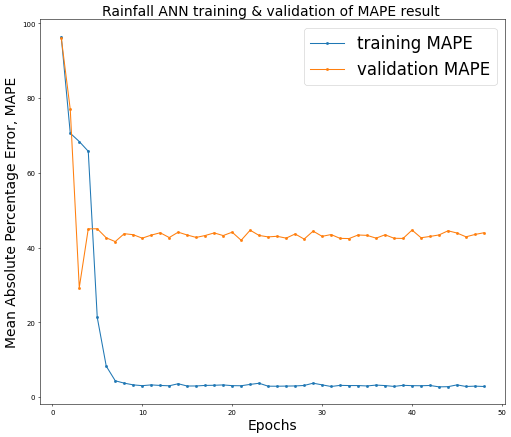

In [ ]:
# 7.2 Plot the history of training and validation
training_acc_values=modeling_result['mean_absolute_percentage_error']
val_acc_values=modeling_result['val_mean_absolute_percentage_error']
epochs=range(1,len(training_acc_values)+1)

plt.figure(figsize=(12,10),dpi=50)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Mean Absolute Percentage Error, MAPE',fontsize=20)
plt.title('Rainfall ANN training & validation of MAPE result ',fontsize=20)

plt.plot(epochs, training_acc_values,marker='.',label='training MAPE')
plt.plot(epochs, val_acc_values,marker='.',label='validation MAPE')
plt.legend(loc=1,fontsize=24)
plt.show()

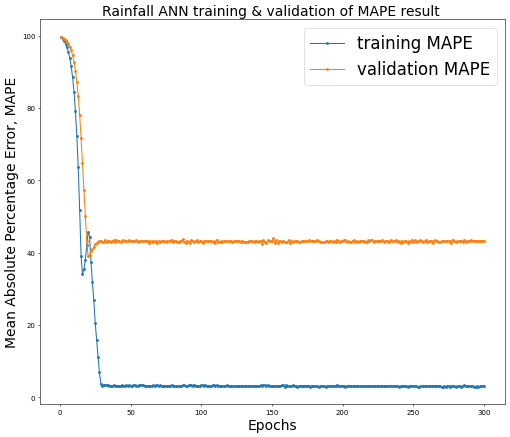

In [ ]:
# 7.2 Plot the history of training and validation
training_acc_values=modeling_result['mean_absolute_percentage_error']
val_acc_values=modeling_result['val_mean_absolute_percentage_error']
epochs=range(1,len(training_acc_values)+1)

plt.figure(figsize=(12,10),dpi=50)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Mean Absolute Percentage Error, MAPE',fontsize=20)
plt.title('Rainfall ANN training & validation of MAPE result ',fontsize=20)

plt.plot(epochs, training_acc_values,marker='.',label='training MAPE')
plt.plot(epochs, val_acc_values,marker='.',label='validation MAPE')
plt.legend(loc=1,fontsize=24)
plt.show()

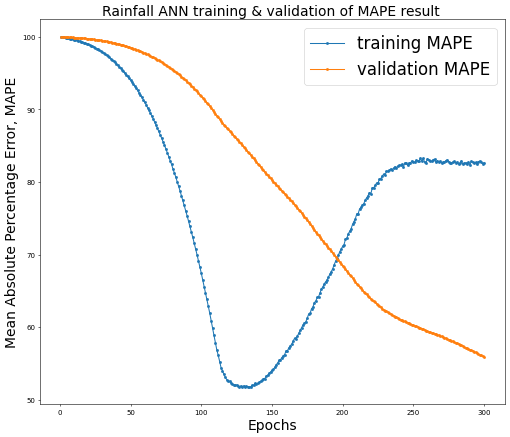

In [ ]:
# 7.2 Plot the history of training and validation
training_acc_values=modeling_result['mean_absolute_percentage_error']
val_acc_values=modeling_result['val_mean_absolute_percentage_error']
epochs=range(1,len(training_acc_values)+1)

plt.figure(figsize=(12,10),dpi=50)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Mean Absolute Percentage Error, MAPE',fontsize=20)
plt.title('Rainfall ANN training & validation of MAPE result ',fontsize=20)

plt.plot(epochs, training_acc_values,marker='.',label='training MAPE')
plt.plot(epochs, val_acc_values,marker='.',label='validation MAPE')
plt.legend(loc=1,fontsize=24)
plt.show()

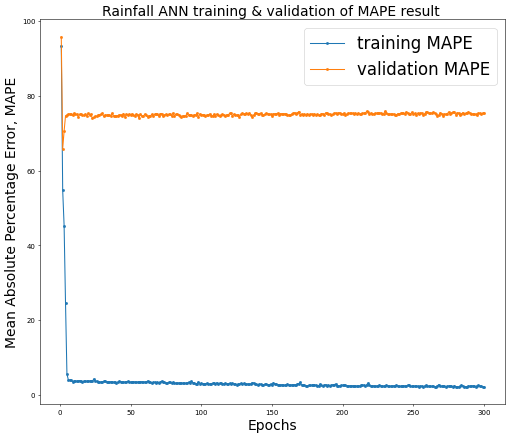

In [ ]:
# 7.2 Plot the history of training and validation
training_acc_values=modeling_result['mean_absolute_percentage_error']
val_acc_values=modeling_result['val_mean_absolute_percentage_error']
epochs=range(1,len(training_acc_values)+1)

plt.figure(figsize=(12,10),dpi=50)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Mean Absolute Percentage Error, MAPE',fontsize=20)
plt.title('Rainfall ANN training & validation of MAPE result ',fontsize=20)

plt.plot(epochs, training_acc_values,marker='.',label='training MAPE')
plt.plot(epochs, val_acc_values,marker='.',label='validation MAPE')
plt.legend(loc=1,fontsize=24)
plt.show()

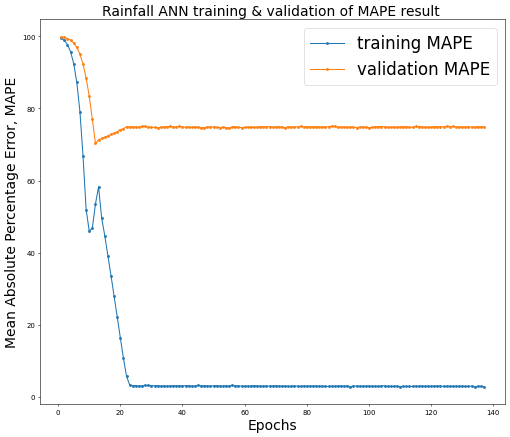

In [ ]:
# 7.2 Plot the history of training and validation
training_acc_values=modeling_result['mean_absolute_percentage_error']
val_acc_values=modeling_result['val_mean_absolute_percentage_error']
epochs=range(1,len(training_acc_values)+1)

plt.figure(figsize=(12,10),dpi=50)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Mean Absolute Percentage Error, MAPE',fontsize=20)
plt.title('Rainfall ANN training & validation of MAPE result ',fontsize=20)

plt.plot(epochs, training_acc_values,marker='.',label='training MAPE')
plt.plot(epochs, val_acc_values,marker='.',label='validation MAPE')
plt.legend(loc=1,fontsize=24)
plt.show()

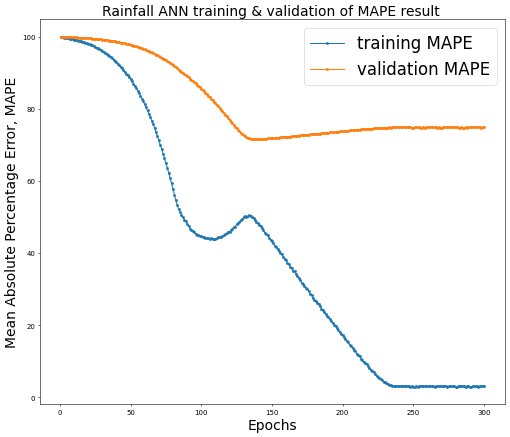

In [ ]:
# 7.2 Plot the history of training and validation
training_acc_values=modeling_result['mean_absolute_percentage_error']
val_acc_values=modeling_result['val_mean_absolute_percentage_error']
epochs=range(1,len(training_acc_values)+1)

plt.figure(figsize=(12,10),dpi=50)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Mean Absolute Percentage Error, MAPE',fontsize=20)
plt.title('Rainfall ANN training & validation of MAPE result ',fontsize=20)

plt.plot(epochs, training_acc_values,marker='.',label='training MAPE')
plt.plot(epochs, val_acc_values,marker='.',label='validation MAPE')
plt.legend(loc=1,fontsize=24)
plt.show()

# Fit the final model with all of the training data

In [ ]:
# Mean and std
rate1 = [28.4741,28.2884,28.3857]
rate2 = [19.8192,19.4861,27.8392]
rate3 = [94.3611,93.5419,93.4107]

mean1 = round(np.average(rate1),4)
mean2 = round(np.average(rate2),4)
mean3 = round(np.average(rate3),4)

std1 = round(np.std(rate1),4)
std2 = round(np.std(rate2),4)
std3 = round(np.std(rate3),4)

print(mean1,mean2,mean3)
print(std1,std2,std3)

28.3827 22.3815 93.7712
0.0758 3.8616 0.4205


In [ ]:
# X all train data
x_forecast_train=Forecast_train_data.drop(['Date','Y'],axis=1).copy()
# Y all train data
y_forecast_train=Forecast_train_data['Y'].copy()

In [ ]:
# 6.1 Create the model
clear.clear_session()
Fmodel=Sequential()

# 6.2 Add input layer & first hidden layer
Fmodel.add(Dense(units=6, input_dim=3, activation='relu'))

# 6.3 Add second hidden layer
Fmodel.add(Dense(units=12, activation='linear'))

# 6.4 Add third hidden layer
Fmodel.add(Dense(units=24, activation='relu'))
Fmodel.add(Dropout(rate=0.002))
Fmodel.add(Dense(units=48, activation='linear'))
Fmodel.add(Dropout(rate=0.03))
Fmodel.add(Dense(units=96, activation='relu'))





# 6.5 Add output layer
Fmodel.add(Dense(units=1, activation='linear'))

# 6.6 Compile the defined Net
#opt=SGD(learning_rate=0.0001,momentum=0.5)
opt=Adam(learning_rate=0.0001,beta_1=0.95)
Fmodel.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
Fmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 48)                1200      
                                                                 
 dropout_1 (Dropout)         (None, 48)                0         
                                                                 
 dense_4 (Dense)             (None, 96)                4

In [ ]:
# Store in the history for more useful information
history=Fmodel.fit(x_forecast_train, y_forecast_train, epochs=300, batch_size=64,verbose=1)

Epoch 1/300
27/27 [==============================] - 1s 3ms/step - loss: 53.1003 - mean_absolute_percentage_error: 95.1534
Epoch 2/300
27/27 [==============================] - 0s 2ms/step - loss: 45.5109 - mean_absolute_percentage_error: 81.5006
Epoch 3/300
27/27 [==============================] - 0s 2ms/step - loss: 36.5106 - mean_absolute_percentage_error: 65.1056
Epoch 4/300
27/27 [==============================] - 0s 2ms/step - loss: 24.5784 - mean_absolute_percentage_error: 43.6108
Epoch 5/300
27/27 [==============================] - 0s 2ms/step - loss: 9.4223 - mean_absolute_percentage_error: 16.2886
Epoch 6/300
27/27 [==============================] - 0s 3ms/step - loss: 3.6970 - mean_absolute_percentage_error: 7.5134
Epoch 7/300
27/27 [==============================] - 0s 2ms/step - loss: 2.5380 - mean_absolute_percentage_error: 4.7124
Epoch 8/300
27/27 [==============================] - 0s 2ms/step - loss: 2.5807 - mean_absolute_percentage_error: 4.8815
Epoch 9/300
27/27 [====

In [ ]:
# 7.3 Save the trained model
#Fmodel.save('D:/data_analysis/PyExport/Rainfall_forecast_ANN_trained_model.h5')
# Colab
Fmodel.save('RE_Final.h5')
print('Model has been saved...')

Model has been saved...


In [ ]:
# 7.4 Restore the saved model for testing
#ANN_model=keras.models.load_model('D:/data_analysis/PyExport/Rainfall_forecast_ANN_trained_model.h5')
# Colab
ANN_model=keras.models.load_model('/content/RE_Final.h5')
print('Model successfully loaded...')

Model successfully loaded...


# 8. Testing

In [ ]:
# X test
x_forecast_test=Forecast_test_data.drop(['Date','Y'],axis=1).copy()
# Y test
y_forecast_test=Forecast_test_data['Y'].copy()

In [ ]:
# 8.1 Make prediction 
prediction=np.round((ANN_model.predict_on_batch(x_forecast_test)),2)
pred_values=[]
for i in range(0,len(prediction)):
    value=prediction[i][0]
    pred_values.append(value)

In [ ]:
Results=pd.DataFrame({'Date':Forecast_test_data['Date'],'Y_true':Forecast_test_data['Y'],'Predict':pred_values})
Results['abs Error']=np.abs(Results['Y_true']-Results['Predict'])
Results

,Date,Y_true,Predict,abs Error
1688,2021/9/16,222.419998,215.539993,6.880005
1689,2021/9/17,219.000000,215.770004,3.229996
1690,2021/9/20,211.130005,213.750000,2.619995
1691,2021/9/21,212.460007,208.679993,3.780014
1692,2021/9/22,219.410004,204.479996,14.930008
...,...,...,...,...
2109,2023/5/19,312.640015,298.290009,14.350006
2110,2023/5/22,311.760010,306.079987,5.680023
2111,2023/5/23,306.880005,301.730011,5.149994
2112,2023/5/24,305.380005,299.619995,5.760010


In [ ]:
# 8.2 Calculating the mertics
MAE=mean_absolute_error(y_forecast_test,pred_values)
MSE=mean_squared_error(y_forecast_test,pred_values,squared=True)
RMSE=mean_squared_error(y_forecast_test,pred_values,squared=False)
MAPE=mean_absolute_percentage_error(y_forecast_test,pred_values)
SMAPE=SMAPE_calulate(y_forecast_test,pred_values)
RAE=RAE_calculate(y_forecast_test,pred_values)
MRAE=MRAE_calculate(y_forecast_test,pred_values)
MdRAE=MdRAE_calculate(y_forecast_test,pred_values)
RSE=RSE_calculate(y_forecast_test,pred_values,Root=False)
RRSE=RSE_calculate(y_forecast_test,pred_values,Root=True)

print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
print('RAE:',round(RAE,3))
print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
print('RSE:',round(RSE,3))
print('RRSE:',round(RRSE,3))

MAE: 9.367
MSE: 153.8
RMSE: 12.402
MAPE: 4.337 %
SMAPE: 4.466 %
RAE: 0.191
MRAE: 0.0004494988448553655
MdRAE: 0.189 bench: 213.2
RSE: 0.048
RRSE: 0.218


#  Plot for comparing true value & predicted value 

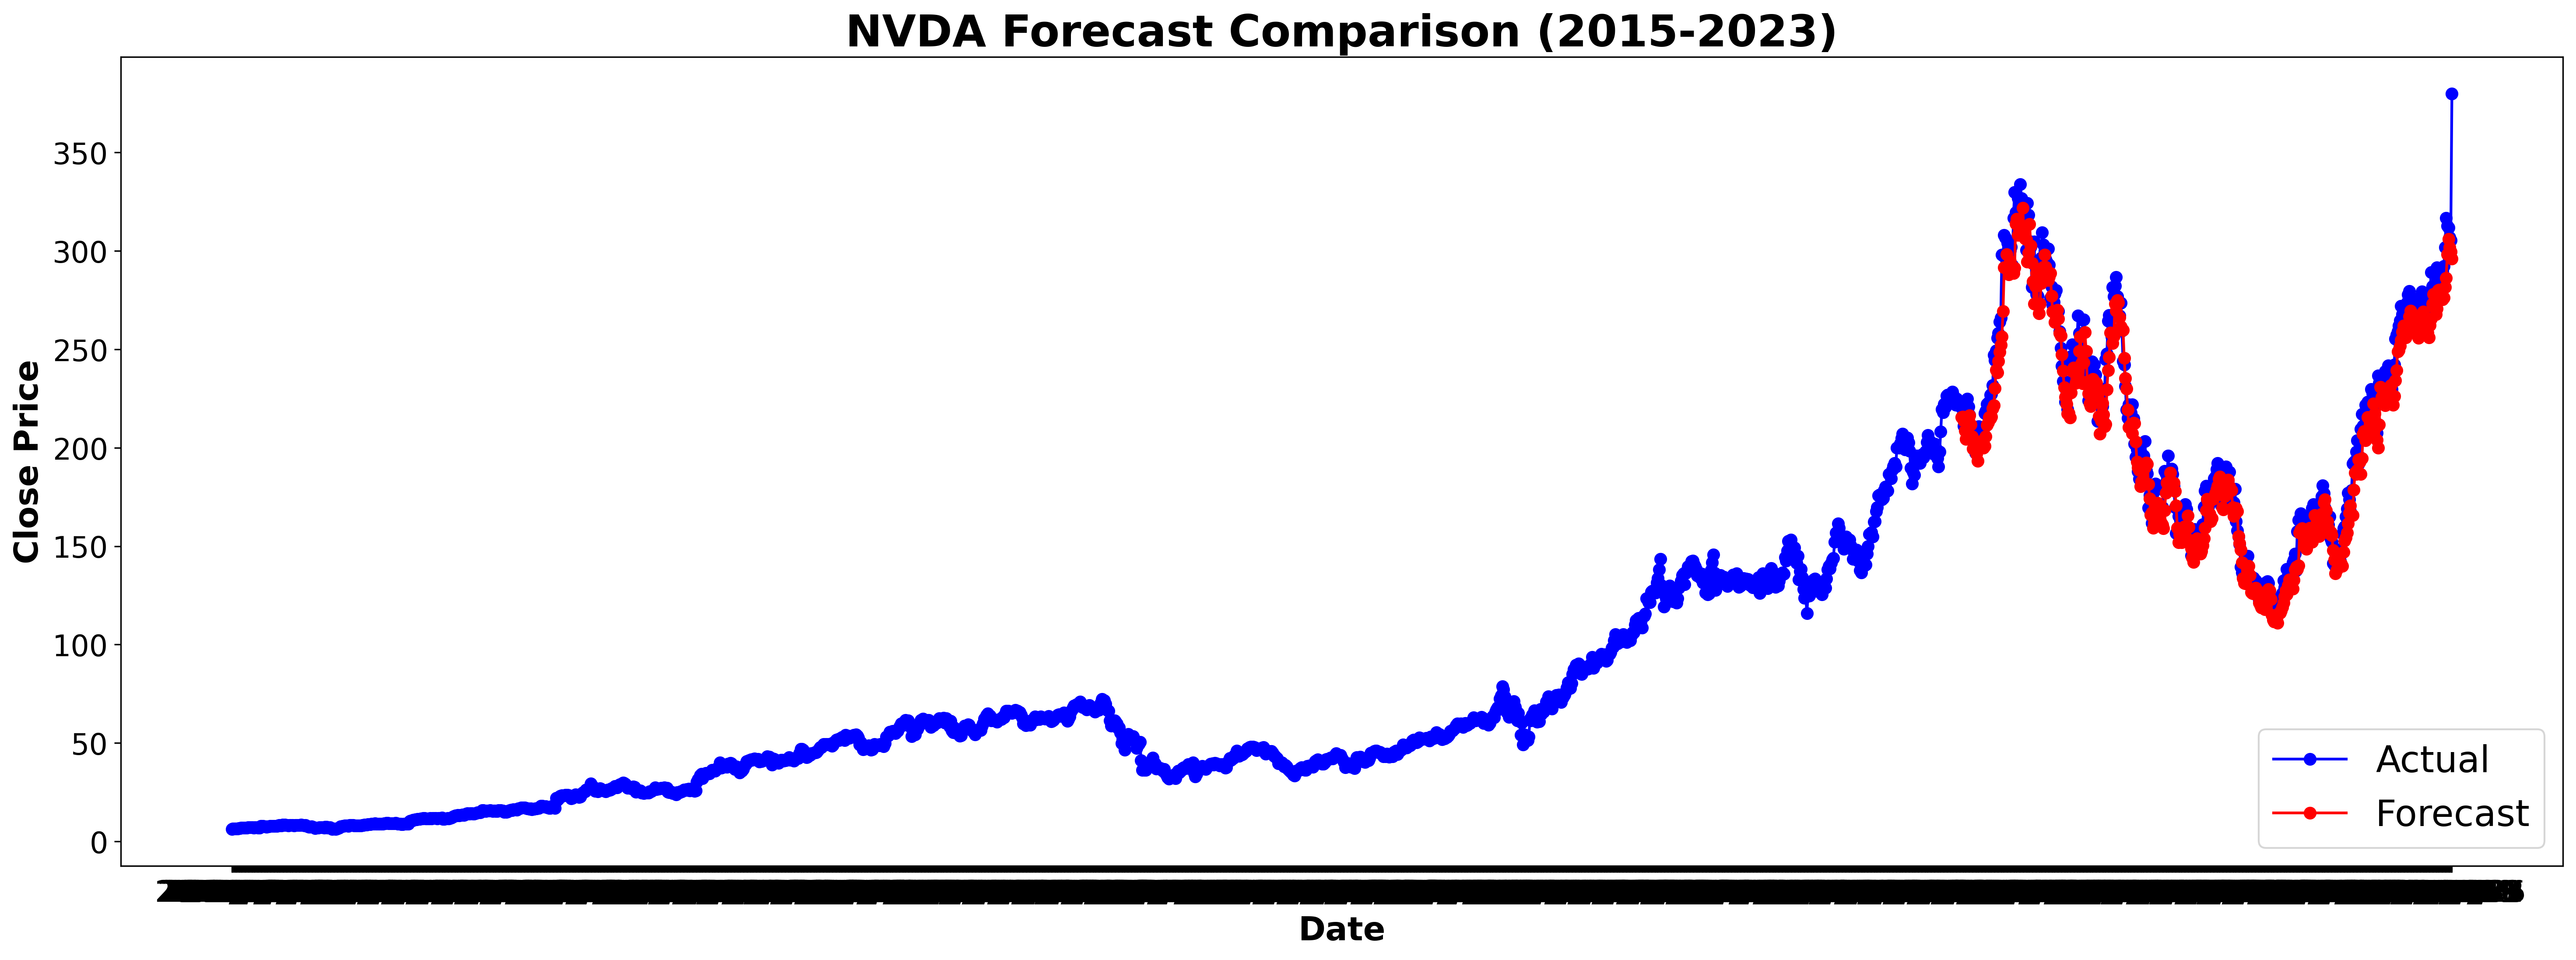

In [ ]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('NVDA Forecast Comparison (2015-2023)',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Close Price',fontsize=18,weight='bold')

# Comparison of actual value and predicted value according to Date
plt.plot(df.iloc[189:,0],df.iloc[189:,1],marker='o',color='blue',label='Actual')
plt.plot(Results['Date'],Results['Predict'],marker='o',color='red',label='Forecast')

# Set the axis
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set legends
plt.legend(loc=4,fontsize=20)

plt.show()

# Actual by predicted plot

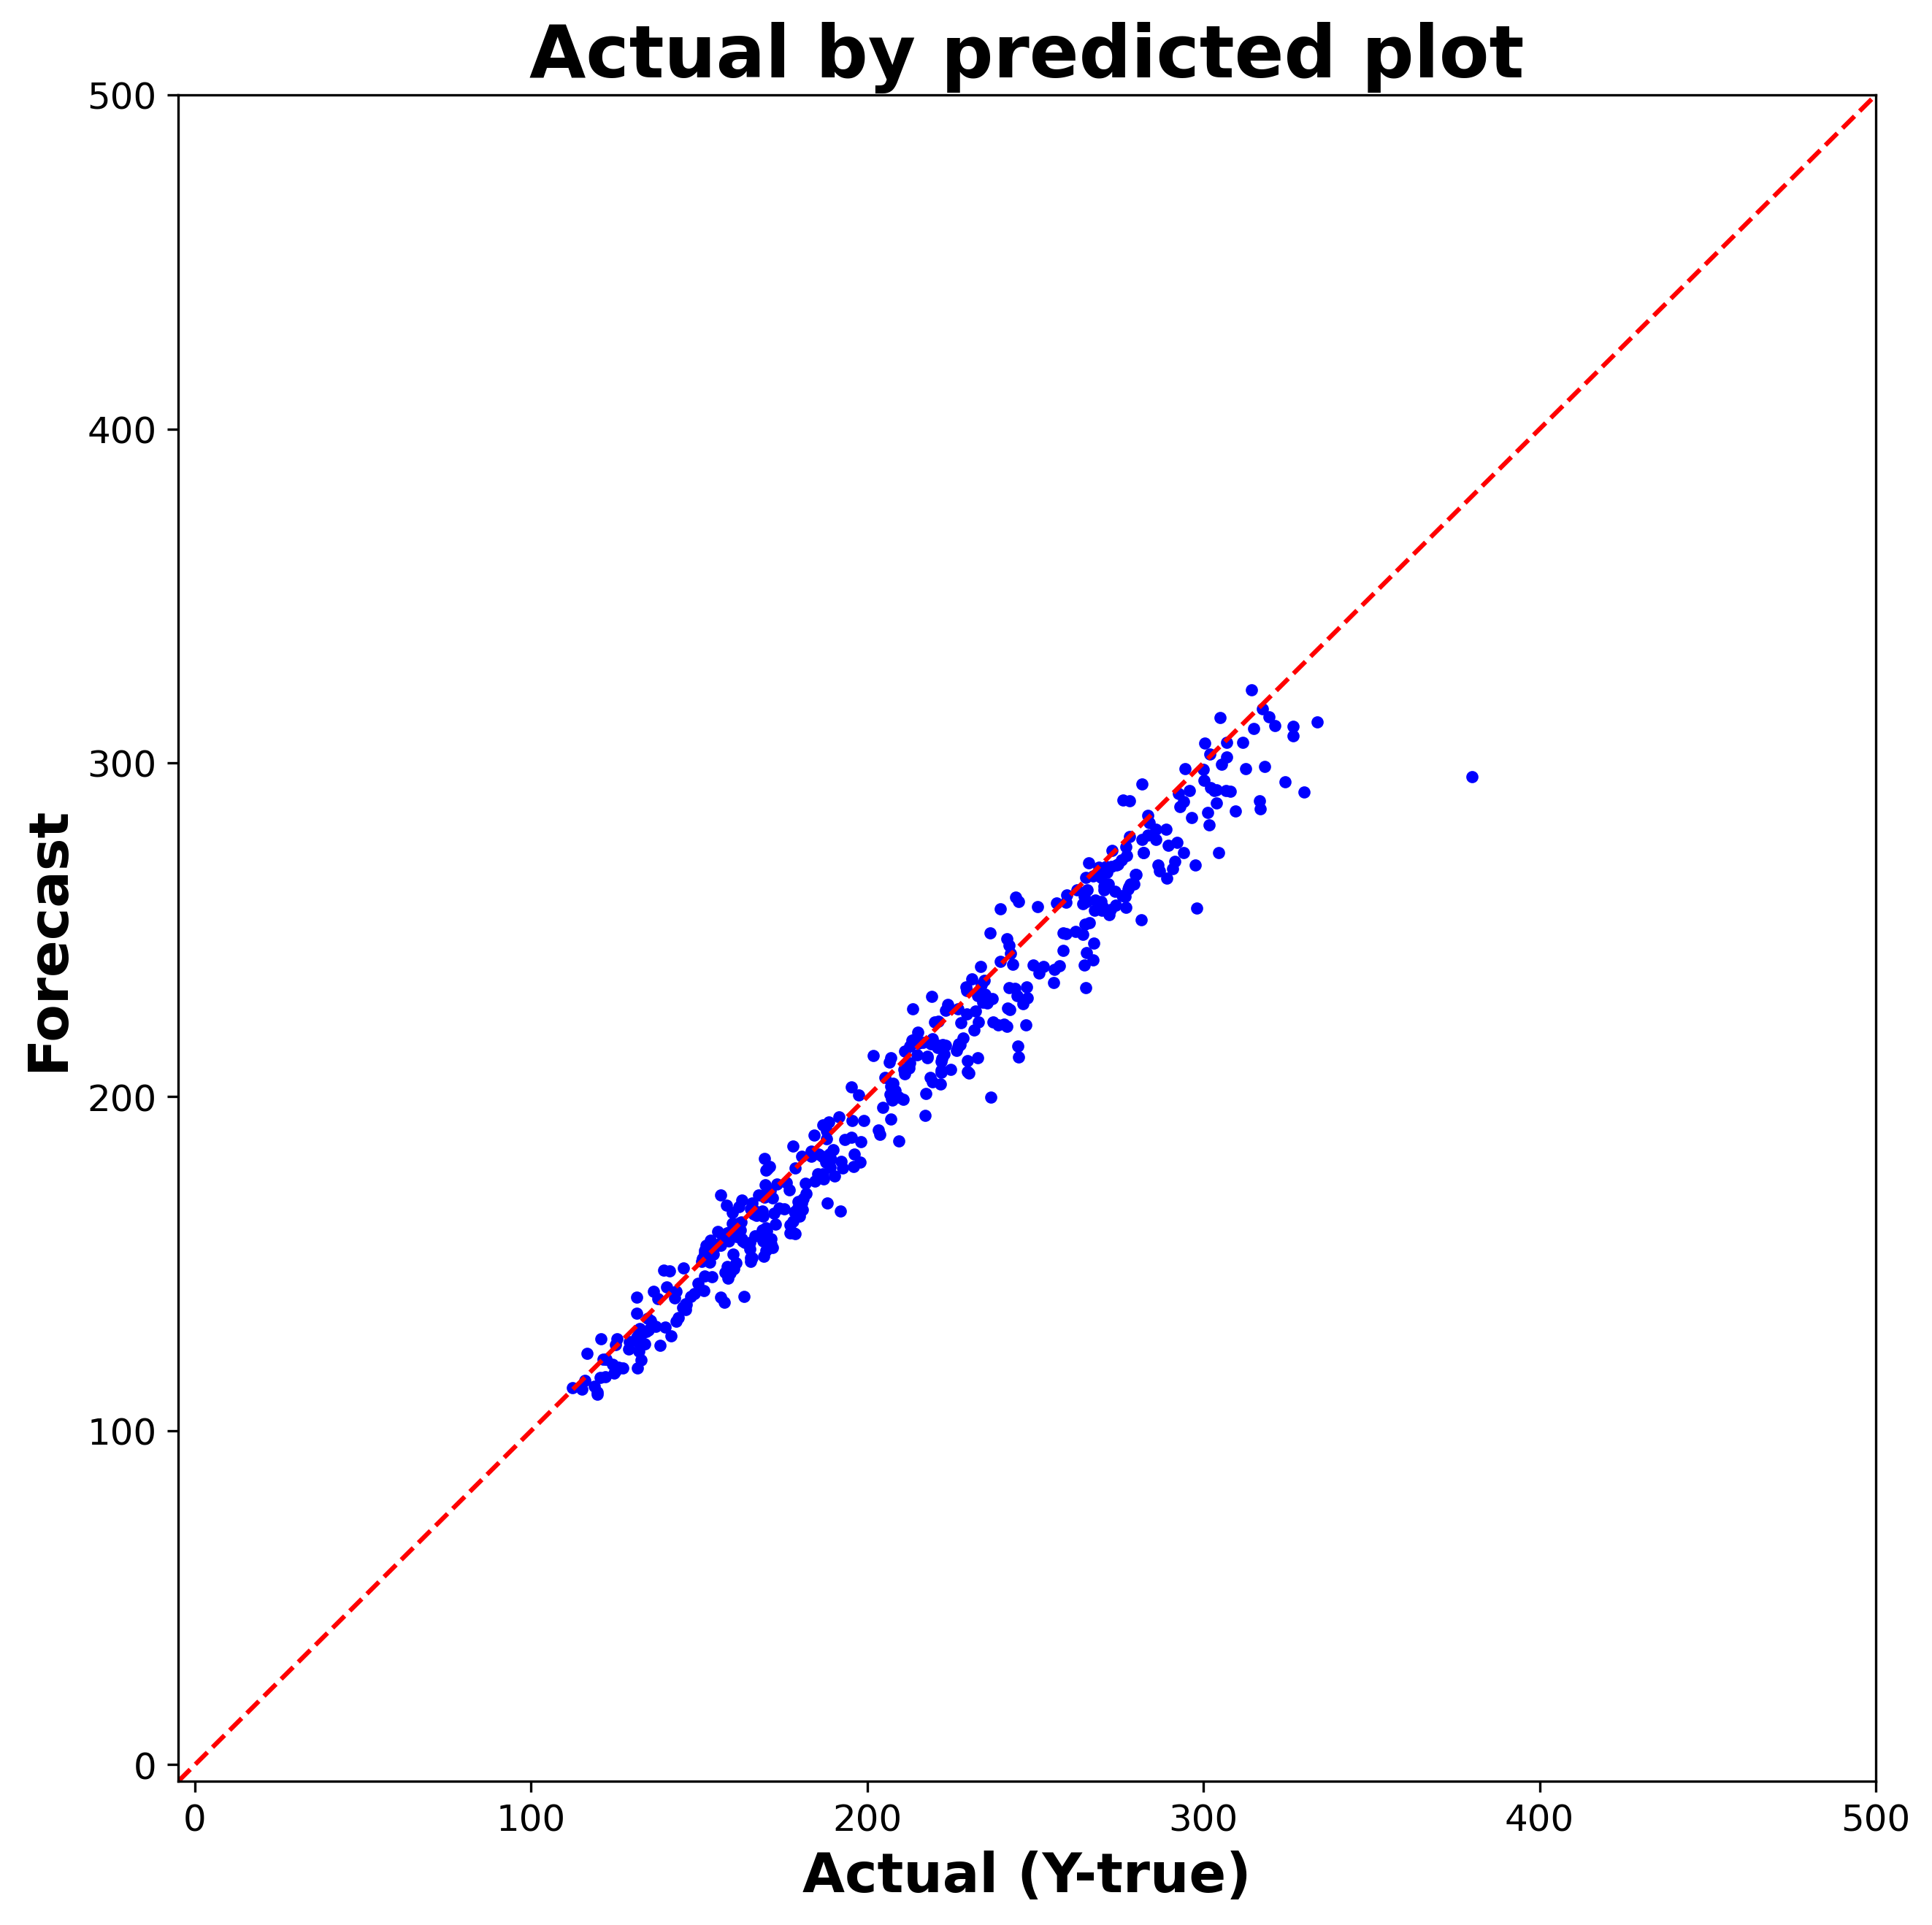

In [ ]:
# Lock the scale of axis by Y_true
max_value=500
min_value=0-5

# Figure setting
plt.figure(figsize=(10,10),dpi=300)
plt.title('Actual by predicted plot',weight='bold',fontsize=24)
plt.xlabel('Actual (Y-true)',fontsize=18,weight='bold')
plt.ylabel('Forecast',fontsize=18,weight='bold')

# Perfect model reference line
plt.plot([min_value,max_value], [min_value,max_value], linestyle='--',color='red')

# Actual by predicted plot
plt.scatter(Results.iloc[:,1],Results.iloc[:,2],marker='.',color='blue')

# Set the axis
plt.ylim(0-5,max_value)
plt.xlim(0-5,max_value)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()